# Проект "Предсказание финальной температуры стали"

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

**В данном проекте нам предстоит построить модель, которая предскажет температуру стали.**

**Чтобы лучше понимать задачу, нам нужно знать как проходит этап обработки:**

- Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

- Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

- Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

- Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных:**

**data_arc.csv** — данные об электродах;

**data_bulk.csv** — данные о подаче сыпучих материалов (объём);

**data_bulk_time.csv** — данные о подаче сыпучих материалов (время);

**data_gas.csv** — данные о продувке сплава газом;

**data_temp.csv** — результаты измерения температуры;

**data_wire.csv** — данные о проволочных материалах (объём);

**data_wire_time.csv** — данные о проволочных материалах (время).

Во всех файлах столбец **key** содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных и план работы

Загрузим данные и проверим общую информацию, оценим, какие данные требуют предобработки.

**После исследовательского анализа данных мы сможем конкретизировать наши планы и подробно расписать каждый пункт предстоящей работы.**

**Первым делом импортируем все библиотеки, которые потребуются нам для работы.**

In [98]:
import pandas as pd

import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns
import pylab

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error

!pip install shap
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 572 kB 1.3 MB/s eta 0:00:01


**Создадим переменные, в которые сохраним данные из файлов.**

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

**Поочерёдно проверим данные каждого датасета:**
 - выведем для проверки первые строки каждого датасета; 
 - посмотрим общую информацию; 
 - посмотрим основные статистические характеристики по каждому числовому признаку; 
 - изучим детальнее каждый столбец;
 - построим диаграммы для визуализации данных.

In [3]:
display(data_arc.head(10))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


**Приведём столбцы в правильный читаемый вид (с учётом рекомендаций PEP8 по написанию кода).**

In [4]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'arc_heating_start_time', 
                                    'Конец нагрева дугой':'arc_heating_finish_time', 
                                    'Активная мощность':'active_power', 
                                    'Реактивная мощность':'reactive_power'})

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   key                      14876 non-null  int64  
 1   arc_heating_start_time   14876 non-null  object 
 2   arc_heating_finish_time  14876 non-null  object 
 3   active_power             14876 non-null  float64
 4   reactive_power           14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


**В этом датасете нет пропусков. Столбцы со временем на следующем этапе нужно будет привести к нужному типу данных - datetime.**

In [6]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


**Мы можем сразу обратить внимание на явную аномалию в столбце с реактивной мощностью - большое отрицательное значение.**

In [7]:
data_arc['key'].value_counts(dropna=False).sort_index(ascending=True)

1       5
2       4
3       5
4       4
5       4
       ..
3237    5
3238    3
3239    8
3240    5
3241    5
Name: key, Length: 3214, dtype: int64

In [8]:
data_arc['arc_heating_start_time'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,arc_heating_start_time
2019-05-03 11:02:14,1
2019-05-03 11:07:28,1
2019-05-03 11:11:44,1
2019-05-03 11:18:14,1
2019-05-03 11:26:09,1
...,...
2019-09-01 03:58:58,1
2019-09-01 04:05:04,1
2019-09-01 04:16:41,1
2019-09-01 04:31:51,1


In [9]:
data_arc['arc_heating_finish_time'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,arc_heating_finish_time
2019-05-03 11:06:02,1
2019-05-03 11:10:33,1
2019-05-03 11:14:36,1
2019-05-03 11:24:19,1
2019-05-03 11:28:37,1
...,...
2019-09-01 04:01:35,1
2019-09-01 04:08:04,1
2019-09-01 04:19:45,1
2019-09-01 04:32:48,1


In [10]:
data_arc['active_power'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,active_power
0.030002,1
0.030188,1
0.030190,1
0.030563,1
0.031630,1
...,...
3.052813,1
3.107820,1
3.150762,1
3.156276,1


In [11]:
data_arc['reactive_power'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,reactive_power
-715.504924,1
0.020806,1
0.021154,1
0.022485,1
0.022983,1
...,...
2.335088,1
2.397032,1
2.459959,1
2.504206,1


**Построим гистограммы для исследования распределения активной и реактивной мощности.**

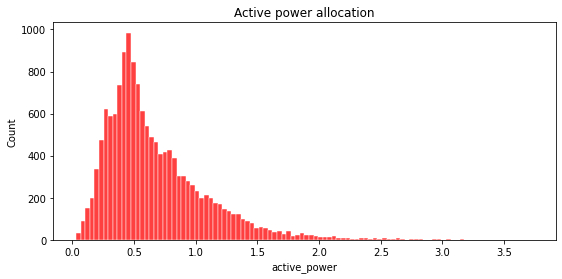

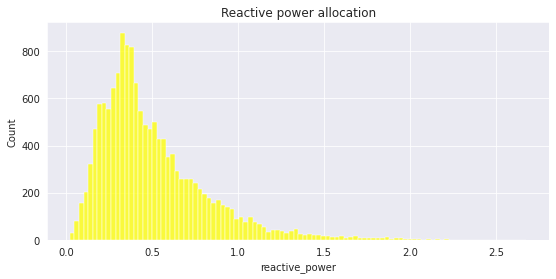

In [12]:
plt.figure(figsize=(9, 4))
plt.title('Active power allocation')

sns.set_style('darkgrid')

sns_plot = sns.histplot(data_arc['active_power'], bins=100, color='red')
fig = sns_plot.get_figure()

plt.figure(figsize=(9, 4))
plt.title('Reactive power allocation')

sns.set_style('darkgrid')

#воспользуемся логической индексацией, чтобы рассмотреть на графике только положительные значения
sns_plot = sns.histplot(data_arc[data_arc['reactive_power'] > 0]['reactive_power'], bins=100, color='yellow') 
fig = sns_plot.get_figure()

**Общий вывод по датасету с данными об электродах:**

В датасете пропусков в данных, в столбах **arc_heating_start_time** и **arc_heating_finish_time** данные нужно привести к типу datetime, мы заметили аномалию в столбце с реактивной мощностью - большое отрицательное значение, разберёмся с этим на этапе предобработки данных. На гистограммах распределения активной и реактивной мощности мы видим **смещённое нормальное распределение**.

In [13]:
display(data_bulk.head(5))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
data_bulk = data_bulk.rename(columns={'Bulk 1':'bulk_first', 
                                      'Bulk 2':'bulk_second', 
                                      'Bulk 3':'bulk_third', 
                                      'Bulk 4':'bulk_fourth',
                                      'Bulk 5':'bulk_fifth', 
                                      'Bulk 6':'bulk_sixth', 
                                      'Bulk 7':'bulk_seventh', 
                                      'Bulk 8':'bulk_eighth',
                                      'Bulk 9':'bulk_ninth', 
                                      'Bulk 10':'bulk_tenth', 
                                      'Bulk 11':'bulk_eleventh', 
                                      'Bulk 12':'bulk_twelfth',
                                      'Bulk 13':'bulk_thirteenth', 
                                      'Bulk 14':'bulk_fourteenth', 
                                      'Bulk 15':'bulk_fifteenth'})

In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3129 non-null   int64  
 1   bulk_first       252 non-null    float64
 2   bulk_second      22 non-null     float64
 3   bulk_third       1298 non-null   float64
 4   bulk_fourth      1014 non-null   float64
 5   bulk_fifth       77 non-null     float64
 6   bulk_sixth       576 non-null    float64
 7   bulk_seventh     25 non-null     float64
 8   bulk_eighth      1 non-null      float64
 9   bulk_ninth       19 non-null     float64
 10  bulk_tenth       176 non-null    float64
 11  bulk_eleventh    177 non-null    float64
 12  bulk_twelfth     2450 non-null   float64
 13  bulk_thirteenth  18 non-null     float64
 14  bulk_fourteenth  2806 non-null   float64
 15  bulk_fifteenth   2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


**В этом датасете есть пропуски, означающие, что сыпучие материалы не добавлялись, поэтому на этапе предобработки данных мы заменим эти пропуски нулями.**

In [16]:
data_bulk.describe()

,key,bulk_first,bulk_second,bulk_third,bulk_fourth,bulk_fifth,bulk_sixth,bulk_seventh,bulk_eighth,bulk_ninth,bulk_tenth,bulk_eleventh,bulk_twelfth,bulk_thirteenth,bulk_fourteenth,bulk_fifteenth
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [17]:
#создадим функцию для автоматизации вывода уникальных значений 
#15 столбцов - уже много для того, чтобы по очереди смотреть каждый

def unique_values(data):
    for column in data.columns:
        print('Столбец', column)
        print(data[column].value_counts(dropna=False).sort_index(ascending=True))
        
unique_values(data_bulk)

Столбец key
1       1
2       1
3       1
4       1
5       1
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: key, Length: 3129, dtype: int64
Столбец bulk_first
10.0        1
16.0        2
19.0        1
21.0        1
22.0        5
24.0        2
26.0        5
27.0       75
28.0       11
29.0        6
30.0        5
31.0       14
32.0        1
33.0        1
34.0        6
36.0        2
37.0        2
38.0        5
39.0        2
41.0        1
43.0        2
44.0       16
46.0       30
47.0        1
48.0       16
50.0        2
51.0        1
52.0        3
54.0       10
58.0        1
60.0        1
62.0        3
63.0        1
65.0        1
67.0        1
69.0        1
73.0        3
74.0        1
75.0        1
78.0        1
83.0        1
90.0        1
92.0        2
94.0        1
104.0       1
118.0       1
185.0       1
NaN      2877
Name: bulk_first, dtype: int64
Столбец bulk_second
228.0       2
232.0       1
233.0       1
236.0       1
242.0       2
246.0       1
247.0       1


<AxesSubplot:>

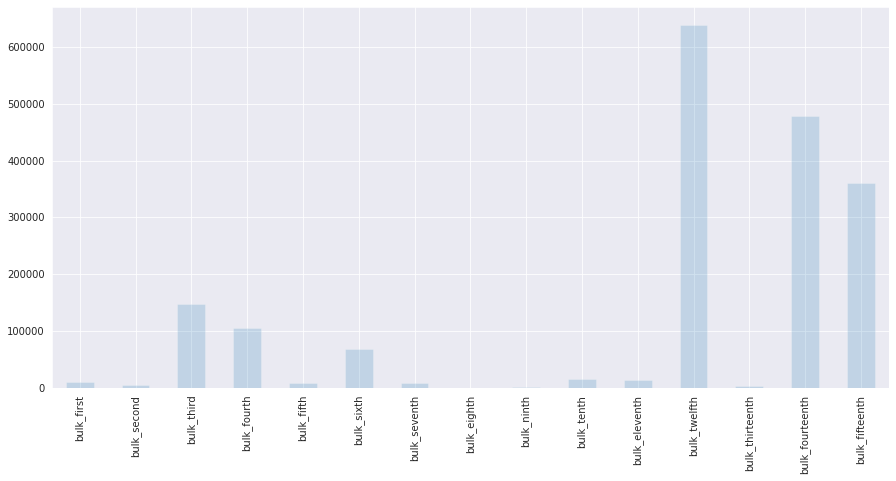

In [19]:
data_bulk[['bulk_first', 'bulk_second', 
           'bulk_third', 'bulk_fourth', 
           'bulk_fifth', 'bulk_sixth',
           'bulk_seventh', 'bulk_eighth',
           'bulk_ninth', 'bulk_tenth',
           'bulk_eleventh', 'bulk_twelfth',
           'bulk_thirteenth', 'bulk_fourteenth', 
           'bulk_fifteenth']].sum().plot(x='bulk_first', kind='bar', figsize=(15, 7), alpha=0.2)

<AxesSubplot:>

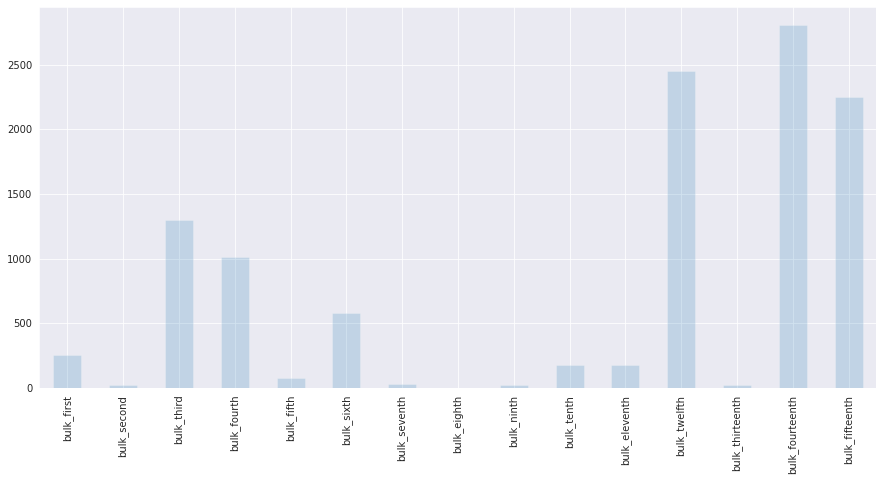

In [20]:
data_bulk[['bulk_first', 'bulk_second', 
           'bulk_third', 'bulk_fourth', 
           'bulk_fifth', 'bulk_sixth',
           'bulk_seventh', 'bulk_eighth',
           'bulk_ninth', 'bulk_tenth',
           'bulk_eleventh', 'bulk_twelfth',
           'bulk_thirteenth', 'bulk_fourteenth', 
           'bulk_fifteenth']].count().plot(x='bulk_first', kind='bar', figsize=(15, 7), alpha=0.2)

**Общий вывод о датасете с данными о подаче сыпучих материалов:**

В этом датасете много пропущенных значений, которые скорее всего означают то, что сыпучие материалы не добавлялись по ходу процесса, на этапе предобработки мы заменим их нулями. 
На столбчатой диаграмме мы видим, что двенадцатая, четырнадцатая и пятнадцатая добавки были добавлены в значительно большем объёме, чем другие добавки, а добавки № 3, 4, 12, 14 и 15 добавляли больше всего раз.

In [21]:
display(data_bulk_time.head(5))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [22]:
data_bulk_time = data_bulk.rename(columns={'Bulk 1':'bulk_first', 
                                           'Bulk 2':'bulk_second', 
                                           'Bulk 3':'bulk_third', 
                                           'Bulk 4':'bulk_fourth',
                                           'Bulk 5':'bulk_fifth', 
                                           'Bulk 6':'bulk_sixth', 
                                           'Bulk 7':'bulk_seventh', 
                                           'Bulk 8':'bulk_eighth',
                                           'Bulk 9':'bulk_ninth', 
                                           'Bulk 10':'bulk_tenth', 
                                           'Bulk 11':'bulk_eleventh', 
                                           'Bulk 12':'bulk_twelfth',
                                           'Bulk 13':'bulk_thirteenth', 
                                           'Bulk 14':'bulk_fourteenth', 
                                           'Bulk 15':'bulk_fifteenth'})

In [23]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3129 non-null   int64  
 1   bulk_first       252 non-null    float64
 2   bulk_second      22 non-null     float64
 3   bulk_third       1298 non-null   float64
 4   bulk_fourth      1014 non-null   float64
 5   bulk_fifth       77 non-null     float64
 6   bulk_sixth       576 non-null    float64
 7   bulk_seventh     25 non-null     float64
 8   bulk_eighth      1 non-null      float64
 9   bulk_ninth       19 non-null     float64
 10  bulk_tenth       176 non-null    float64
 11  bulk_eleventh    177 non-null    float64
 12  bulk_twelfth     2450 non-null   float64
 13  bulk_thirteenth  18 non-null     float64
 14  bulk_fourteenth  2806 non-null   float64
 15  bulk_fifteenth   2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


**В этом датасете, также как и в предыдущем, есть пропуски, а также несоответствующий тип данных. Но мы не будем использовать этот датасет для выработки признаков, поэтому предобработка данных тут не потребуется.**

In [24]:
display(data_gas.head(5))

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [25]:
data_gas = data_gas.rename(columns={'Газ 1':'gas'})

In [26]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**В этом датасете нет пропусков.**

In [27]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


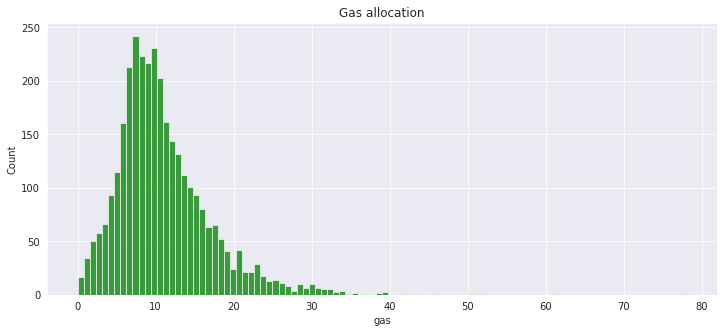

In [28]:
plt.figure(figsize=(12, 5))
plt.title('Gas allocation')

sns.set_style('darkgrid')

sns_plot = sns.histplot(data_gas['gas'], bins=100, color='green')
fig = sns_plot.get_figure()

**Общие выводы по датасету с информацией о продувке сплава газом:**

В датасете нет пропущенных значений, гистограмма показывает **смещённое нормальное распределение** данных. 

In [29]:
display(data_temp.head(5))

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [30]:
data_temp = data_temp.rename(columns={'Время замера':'measurement_time', 'Температура':'temperature'})

In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               15907 non-null  int64  
 1   measurement_time  15907 non-null  object 
 2   temperature       13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


**В этом датасете есть пропуски. Также, в столбце с временем замера требуется изменение типа данных.**

In [32]:
data_temp.describe()

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


**По сообщению заказчика температуры ниже 1500 градусов - аномалии, мы их рассматривать не будем.**

In [33]:
data_temp['measurement_time'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,measurement_time
2019-05-03 11:16:18,1
2019-05-03 11:25:53,1
2019-05-03 11:29:11,1
2019-05-03 11:30:01,1
2019-05-03 11:30:39,1
...,...
2019-09-01 04:03:30,1
2019-09-01 04:16:12,1
2019-09-01 04:22:39,1
2019-09-01 04:33:42,1


In [34]:
data_temp['temperature'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,temperature
1191.0,1
1204.0,1
1208.0,1
1218.0,1
1227.0,1
...,...
1700.0,1
1702.0,1
1704.0,1
1705.0,1


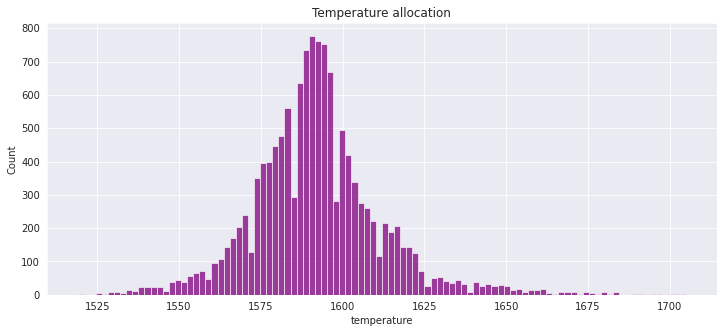

In [35]:
plt.figure(figsize=(12, 5))
plt.title('Temperature allocation')

sns.set_style('darkgrid')

sns_plot = sns.histplot(data_temp[data_temp['temperature'] >= 1500]['temperature'], bins=100, color='purple')
fig = sns_plot.get_figure()

**Общий вывод по датасету с информацией об измерении температуры:**

В датасете присутствуют пропуски, также, в столбце со временем замера требуется изменение типа данных на datetime. По сообщению заказчика температура ниже 1500 градусов - это аномалия, которую мы рассматривать не будем, поэтому график мы построили без учёта этой аномалии, на гистограмме мы видим **нормальное распределение без смещения**. 

In [36]:
display(data_wire.head(5))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_wire = data_wire.rename(columns={'Wire 1':'wire_first', 
                                      'Wire 2':'wire_second', 
                                      'Wire 3':'wire_third', 
                                      'Wire 4':'wire_fourth',
                                      'Wire 5':'wire_fifth', 
                                      'Wire 6':'wire_sixth', 
                                      'Wire 7':'wire_seventh', 
                                      'Wire 8':'wire_eighth',
                                      'Wire 9':'wire_ninth'})

In [38]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3081 non-null   int64  
 1   wire_first    3055 non-null   float64
 2   wire_second   1079 non-null   float64
 3   wire_third    63 non-null     float64
 4   wire_fourth   14 non-null     float64
 5   wire_fifth    1 non-null      float64
 6   wire_sixth    73 non-null     float64
 7   wire_seventh  11 non-null     float64
 8   wire_eighth   19 non-null     float64
 9   wire_ninth    29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**В этом датасете присутствуют пропуски. Как и в случае с сыпучими материалами, мы заменим пропуски на нули.**

In [39]:
data_wire.describe()

,key,wire_first,wire_second,wire_third,wire_fourth,wire_fifth,wire_sixth,wire_seventh,wire_eighth,wire_ninth
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [40]:
unique_values(data_wire)

Столбец key
1       1
2       1
3       1
4       1
5       1
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: key, Length: 3081, dtype: int64
Столбец wire_first
1.918800       1
2.096640       1
3.101280       1
4.018560       1
4.062240       2
              ..
248.102394     1
249.958786     1
280.987214     1
330.314424     1
NaN           26
Name: wire_first, Length: 2252, dtype: int64
Столбец wire_second
0.030160         1
0.060320         1
0.090480         1
0.090480         1
0.174720         1
              ... 
219.866410       1
220.348953       1
231.568481       1
282.780152       1
NaN           2002
Name: wire_second, Length: 714, dtype: int64
Столбец wire_third
0.144144         3
0.528528         1
0.960960         1
88.648567        1
90.138054        1
93.068977        1
93.117027        2
93.165077        3
93.213127        1
94.126038        1
94.990898        1
95.279190        1
95.375282        1
96.047951        1
96.096001        1
96.192101  

<AxesSubplot:>

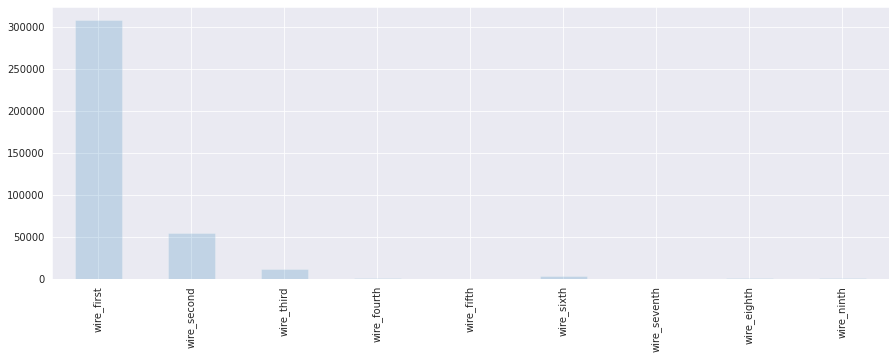

In [41]:
data_wire[['wire_first', 'wire_second', 
           'wire_third', 'wire_fourth', 
           'wire_fifth', 'wire_sixth',
           'wire_seventh', 'wire_eighth',
           'wire_ninth']].sum().plot(x='wire_first', kind='bar', figsize=(15, 5), alpha=0.2)

<AxesSubplot:>

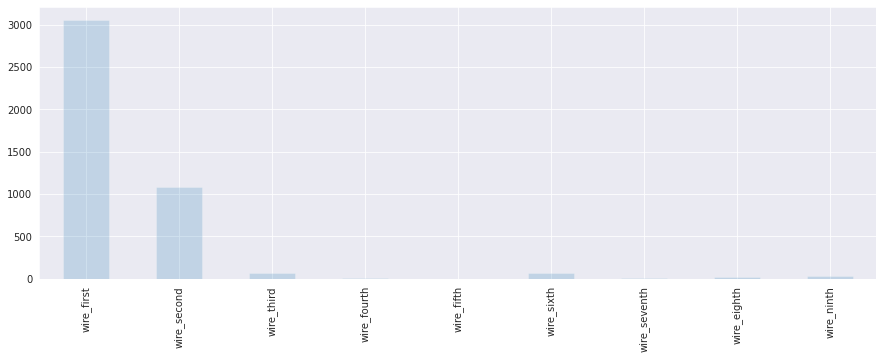

In [42]:
data_wire[['wire_first', 'wire_second', 
           'wire_third', 'wire_fourth', 
           'wire_fifth', 'wire_sixth',
           'wire_seventh', 'wire_eighth',
           'wire_ninth']].count().plot(x='wire_first', kind='bar', figsize=(15, 5), alpha=0.2)

**Общий вывод по датасету с информацией о проволочных материалах:**

В датасете есть пропуски, которые на предобработке мы заменим на нули. Согласно столбчатой диаграмме, первую, вторую и третью проволоку при легировании стали добавляли чаще и в большем объеме, чем другие. 

In [43]:
display(data_wire_time.head(5))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
data_wire_time = data_wire_time.rename(columns={'Wire 1':'wire_first', 
                                                'Wire 2':'wire_second', 
                                                'Wire 3':'wire_third', 
                                                'Wire 4':'wire_fourth',
                                                'Wire 5':'wire_fifth', 
                                                'Wire 6':'wire_sixth', 
                                                'Wire 7':'wire_seventh', 
                                                'Wire 8':'wire_eighth',
                                                'Wire 9':'wire_ninth'})

In [45]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           3081 non-null   int64 
 1   wire_first    3055 non-null   object
 2   wire_second   1079 non-null   object
 3   wire_third    63 non-null     object
 4   wire_fourth   14 non-null     object
 5   wire_fifth    1 non-null      object
 6   wire_sixth    73 non-null     object
 7   wire_seventh  11 non-null     object
 8   wire_eighth   19 non-null     object
 9   wire_ninth    29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


**В этом датасете также не соответствует тип данных, но мы не будем использовать данные из этого датасета в будущем.**

# Вывод после исследовательского анализа данных

**Мы исследовали наши данные и теперь можно составить подробный план нашей работы.**

**Перед нами стоит задача прогнозирования финальной температуры.**

**Наша цель - построить модель, с помощью которой закзчик сможет экспериментальным путём воспроизвести технологический процесс, не неся потерь (электроэнергия и ресурсы), а тестировать непосредственно на производстве уже лучший результат.**

- **Первый этап.** Предобработка данных
 - Датасеты с данными о времени мы отсеим для финальной таблицы и не будем использовать для модели (data_bulk_time и data_wire_time).
 - Температуры ниже 1500 градусов - аномалии, от них избавимся.
 - В столбцах с датами нужно привести данные к типу datetime.
 - В столбце reactive_power избавимся от аномального значения отрицательной мощности. 
 - Поработаем с пропусками, которые мы обнаружили в данных.
 - Мы должны учесть разное количество уникальных номеров партии key в наших датасетах.
 
- **Второй этап.** Построение моделей.
 - В проекте мы рассмотрим три модели: RandomForestRegressor, CatBoostRegressor, LGBMRegressor 
 - Лучшую модель проверим на тестовом наборе данных
 
- **Третий этап.** Составление отчёта для заказчика.
 - В этом отчёте мы должны наиболее полно описать нашу работу в ходе проекта, какие результаты получены и какие выводы можно сделать.

## Предобработка данных и подготовка признаков для построения модели

- **Первым делом заменим пропуски на нули в датасетах с сыпучими и проволочными материалами.**
- **Затем поменяем типы данных на datetime в датасете с температурой.**
- **Отсеим температуры ниже 1500 градусов.**
- **Избавимся от отрицательных значений реактивной мощности.**

In [46]:
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3129 non-null   int64  
 1   bulk_first       3129 non-null   float64
 2   bulk_second      3129 non-null   float64
 3   bulk_third       3129 non-null   float64
 4   bulk_fourth      3129 non-null   float64
 5   bulk_fifth       3129 non-null   float64
 6   bulk_sixth       3129 non-null   float64
 7   bulk_seventh     3129 non-null   float64
 8   bulk_eighth      3129 non-null   float64
 9   bulk_ninth       3129 non-null   float64
 10  bulk_tenth       3129 non-null   float64
 11  bulk_eleventh    3129 non-null   float64
 12  bulk_twelfth     3129 non-null   float64
 13  bulk_thirteenth  3129 non-null   float64
 14  bulk_fourteenth  3129 non-null   float64
 15  bulk_fifteenth   3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [47]:
data_wire = data_wire.fillna(0)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3081 non-null   int64  
 1   wire_first    3081 non-null   float64
 2   wire_second   3081 non-null   float64
 3   wire_third    3081 non-null   float64
 4   wire_fourth   3081 non-null   float64
 5   wire_fifth    3081 non-null   float64
 6   wire_sixth    3081 non-null   float64
 7   wire_seventh  3081 non-null   float64
 8   wire_eighth   3081 non-null   float64
 9   wire_ninth    3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**В датасете с информацией об измерении температуры также присутствуют пропуски, мы удалим эти пропуски и не будем их заменять, так как температура - наш целевой признак и нам нужна максимальная достоверность.**
**Также, сразу отсечём аномальные значения.**

In [48]:
data_temp = data_temp.dropna(subset=['temperature'])

limitation_key = data_temp[data_temp['temperature'] < 1500]['key'].unique()
data_temp = data_temp.query('key not in @limitation_key')
data_temp = data_temp.reset_index(drop=True)

data_temp['temperature'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

,temperature
1519.0,1
1520.0,2
1525.0,2
1526.0,4
1527.0,2
...,...
1696.0,1
1700.0,1
1702.0,1
1704.0,1


**Поменяем тип данных на datetime в столбце measurement_time и сделаем проверку.**

In [49]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'], format='%Y/%m/%d')
data_temp.info()
data_temp['measurement_time'].value_counts(dropna=False).sort_index(ascending=True).to_frame()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12961 entries, 0 to 12960
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               12961 non-null  int64         
 1   measurement_time  12961 non-null  datetime64[ns]
 2   temperature       12961 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 303.9 KB


,measurement_time
2019-05-03 11:16:18,1
2019-05-03 11:25:53,1
2019-05-03 11:29:11,1
2019-05-03 11:30:01,1
2019-05-03 11:30:39,1
...,...
2019-08-31 22:44:04,1
2019-08-31 23:30:31,1
2019-09-01 01:31:47,1
2019-09-01 02:39:01,1


**Поменяем тип данных на datetime в столбцах arc_heating_start_time и arc_heating_finish_time.**

In [50]:
data_arc['arc_heating_start_time'] = pd.to_datetime(data_arc['arc_heating_start_time'], format='%Y/%m/%d')
data_arc['arc_heating_finish_time'] = pd.to_datetime(data_arc['arc_heating_finish_time'], format='%Y/%m/%d')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   key                      14876 non-null  int64         
 1   arc_heating_start_time   14876 non-null  datetime64[ns]
 2   arc_heating_finish_time  14876 non-null  datetime64[ns]
 3   active_power             14876 non-null  float64       
 4   reactive_power           14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


**Отсечём аномальные значения реактивной мощности.**

In [51]:
data_arc = data_arc.query('reactive_power > 0')
data_arc.describe()

,key,active_power,reactive_power
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


**Мы сделали первичную предобработку данных, теперь подготовим данные для работы модели.**
**Нам нужно понять, какие признаки нам обозначить для обучения модели, что конкретно будет важно для предсказания конечной температуры.** 

- Нам нужно поработать с датасетом температуры и вычленить стартовую и финальную температуру. Финальная температура - наш целевой признак. Также нужно учесть, что мы не можем брать те наблюдения, в которых есть только один замер температуры (не важно, первый или последний).

- Нужно подумать, как реализовать признаки активной и реактивной мощности. Выведем новый признак - полную мощность - который будем использовать вместо этих двух. Полная мощность будет равна квадратному корню из суммы квадратов активной и реактивной мощности.
 - также, можно рассчитать КПД, и проверить корреляции этих признаков с финальной температурой; оказавший большее влияние на температуру признак мы будем использовать в финальной таблице.
 
- Сформируем финальный датасет.

**Сначала поработаем с температурой**.
Наша задача - оставить только начальную и конечную температуры, без промежуточных измерений. Затем мы удалим те наблюдения, в которых есть только одна температура. 

Удалим те наблюдения, где известна только одна температура. Создадим пустую переменную, в которую с помощью цикла for добавим те, значения, где максимальная температура для одного ключа совпадает с минимальной (т.е. начальной) температурой для того же ключа. Дальше с помощью среза оставим те ключи, которые отсутствуют в новой переменной и почистим датасет.

In [52]:
lost_temp_counter = []

for key in list(data_temp['key'].unique()):
    if data_temp[data_temp['key'] == key]['measurement_time'].max() == data_temp[data_temp['key'] == key]['measurement_time'].min():
        lost_temp_counter.append(key)
        
data_temp = data_temp.query('key not in @lost_temp_counter')
data_temp = data_temp.dropna()
display(data_temp)

,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12218,2498,2019-08-06 02:19:26,1593.0
12219,2498,2019-08-06 02:25:31,1594.0
12220,2499,2019-08-06 02:40:25,1569.0
12221,2499,2019-08-06 02:54:24,1604.0


Создадим новый датасет, в котором с помощью сводной таблицы оставим два столбца из датасета с информацией об измерении температуры - начальное и конечное время стадии нагревания для каждого ключа. 

In [53]:
data_temp_time = data_temp.pivot_table(index='key', values='measurement_time', 
                                       aggfunc={'measurement_time': [np.min, np.max]})
data_temp_time.columns = ['finish_heating', 'start_heating']
display(data_temp_time.head(10))

,finish_heating,start_heating
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
6,2019-05-03 14:12:29,2019-05-03 13:49:24
7,2019-05-03 14:42:37,2019-05-03 14:19:43
8,2019-05-03 15:22:52,2019-05-03 15:07:18
9,2019-05-03 16:01:16,2019-05-03 15:37:03


С помощью среза оставим те значения температуры (начальной и финальной), которые совпадают со значением времени первого и последнего замера из нашей сводной таблицы.

In [54]:
start = list(data_temp_time['start_heating'])
start_heating = data_temp.query('measurement_time in @start')
start_heating = start_heating.set_index('key')

finish = list(data_temp_time['finish_heating'])
finish_heating = data_temp.query('measurement_time in @finish')
finish_heating = finish_heating.set_index('key')

In [55]:
temp_final = start_heating
temp_final.columns = ['measurement_time', 'start_heating']
temp_final['finish_heating'] = finish_heating['temperature']
temp_final = temp_final.drop('measurement_time', axis=1)

display(temp_final)

,start_heating,finish_heating
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


**Удалим два признака из датасета с информацией об электродах - начало и конец нагрева дугой.**

In [56]:
data_arc = data_arc.drop(['arc_heating_start_time', 'arc_heating_finish_time'], axis=1)
display(data_arc)

,key,active_power,reactive_power
0,1,0.976059,0.687084
1,1,0.805607,0.520285
2,1,0.744363,0.498805
3,1,1.659363,1.062669
4,1,0.692755,0.414397
...,...,...,...
14871,3241,0.533670,0.354439
14872,3241,0.676604,0.523631
14873,3241,0.733899,0.475654
14874,3241,0.220694,0.145768


**Создадим два новых признака:**
- Полная мощность - квадратный корень из суммы квадратой активной и реактивной мощности.
- КПД - отношение полезной мощности (активная мощность) к полной мощности.

In [57]:
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)
data_arc['efficiency_factor'] = data_arc['active_power'] / data_arc['full_power']
display(data_arc.head())

,key,active_power,reactive_power,full_power,efficiency_factor
0,1,0.976059,0.687084,1.193639,0.817717
1,1,0.805607,0.520285,0.959010,0.840041
2,1,0.744363,0.498805,0.896038,0.830728
3,1,1.659363,1.062669,1.970470,0.842115
4,1,0.692755,0.414397,0.807239,0.858178


Проверим корреляцию полной мощности и КПД к финальной температуре.

In [58]:
data_arc['full_power'].corr(temp_final['finish_heating'])

0.0043443058886587105

In [59]:
data_arc['efficiency_factor'].corr(temp_final['finish_heating'])

-0.004268857287770202

КПД отличился слабой отрицательной связью, этот признак можно удалить и не использовать. 

In [60]:
data_arc['active_power'].corr(temp_final['finish_heating'])

0.003578940871622045

In [61]:
data_arc['reactive_power'].corr(temp_final['finish_heating'])

0.005072681609431477

Оба признака - активная и реактивная мощность - обладают очень слабой положительной корреляцией с нашим целевым признаком. Оставим только полную мощность и с помощью сводной таблицы сагрегируем датасет по её значению.

In [62]:
data_arc = data_arc.drop('efficiency_factor', axis=1)
data_arc = data_arc.drop('active_power', axis=1)

In [63]:
data_arc_fin = data_arc.pivot_table(index='key', values='full_power', aggfunc='sum')
display(data_arc_fin)

,full_power
key,
1,5.826395
2,3.649216
3,2.989534
4,3.814962
5,4.035758
...,...
3237,4.844982
3238,2.696542
3239,5.611883


Удалим сыпучие и проволочные материалы, которые добавлялись меньше всего согласно нашим столбчатым диаграммам.

In [64]:
data_bulk = data_bulk.drop('bulk_eighth', axis=1)

In [65]:
data_wire = data_wire.drop('wire_fifth', axis=1)

**Объединим наши проработанные датасеты в один с помощью функции merge().**

In [66]:
data = data_arc_fin.merge(right = temp_final, how = 'inner', on = 'key')
data = data.merge(right = data_bulk, how = 'inner', on = 'key')
data = data.merge(right = data_gas, how = 'inner', on = 'key')
data = data.merge(right = data_wire, how = 'inner', on = 'key')
display(data)

,key,full_power,start_heating,finish_heating,bulk_first,bulk_second,bulk_third,bulk_fourth,bulk_fifth,bulk_sixth,...,bulk_fifteenth,gas,wire_first,wire_second,wire_third,wire_fourth,wire_sixth,wire_seventh,wire_eighth,wire_ninth
0,1,5.826395,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,3.649216,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2.989534,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.814962,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4.035758,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,3.986869,1570.0,1591.0,0.0,0.0,21.0,0.0,0.0,0.0,...,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,5.057033,1554.0,1591.0,0.0,0.0,0.0,63.0,0.0,0.0,...,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,2.885017,1571.0,1589.0,0.0,0.0,0.0,85.0,0.0,0.0,...,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,4.143749,1591.0,1594.0,0.0,0.0,90.0,0.0,0.0,0.0,...,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
data = data.drop('key', axis=1)
data.corr()['finish_heating'].sort_values(ascending=False).to_frame()

,finish_heating
finish_heating,1.000000
wire_first,0.317702
start_heating,0.301961
full_power,0.273388
bulk_twelfth,0.267379
bulk_fifteenth,0.266386
bulk_fourth,0.188100
bulk_fourteenth,0.114520
bulk_tenth,0.061345
gas,0.059036


**Для наглядности дополнительно построим график корреляции.**

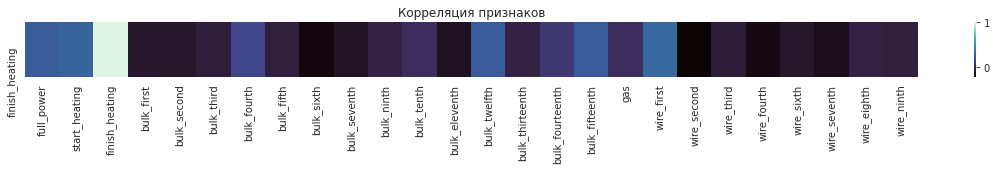

In [84]:
data_corr = data.corr()

f, ax = plt.subplots(figsize = (20, 1))

sns.heatmap(data_corr.sort_values(by = ['finish_heating'], ascending=False).head(1), 
            cmap = sns.color_palette('mako', as_cmap=True))
plt.title('Корреляция признаков', fontsize=12)
plt.show()

Самая сильная корреляция между конечной температурой и добавлением проволоки №1, начальной температурой, полной мощностью и добавлением сыпучих материалов под номерами 12 и 14. Также, мы можем наблюдать отрицательную корреляцию с добавлением сыпучих материалов №3 и проволоками №2, 3 и 6. Это значит, что при увеличении одного показателя будет уменьшатся другая.

## Построение моделей

**Разобьём наши данные в соотношении 75/25 на обучающую и тестовую выборки соответственно.**

In [85]:
features = data.drop('finish_heating', axis=1) 
target = data['finish_heating']

In [86]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=110423)

**Обучим модель случайного леса в регрессии.**

In [87]:
%%time

parameters = {'n_estimators': range(1, 50), 'max_depth': range(1, 13)}

model = RandomForestRegressor(random_state = 110423)
forest_model = GridSearchCV(model, parameters, cv = 5, scoring = 'neg_mean_absolute_error')
forest_model = forest_model.fit(features_train, target_train)

print('Лучшее значение метрики MAE для случайного леса:', -forest_model.best_score_)
print('Лучшие параметры:', forest_model.best_params_)

Лучшее значение метрики MAE для случайного леса: 6.241650297722771
Лучшие параметры: {'max_depth': 11, 'n_estimators': 49}
CPU times: user 6min 6s, sys: 1.72 s, total: 6min 7s
Wall time: 6min 9s


**Обучим модель CatBoostRegressor.**

In [88]:
%%time

parameters = [{'learning_rate':[0.1, 0.5, 0.8]}]

model = CatBoostRegressor(loss_function = 'MAE', random_state = 110423, verbose = False) 
cat_model = GridSearchCV(model, parameters, cv = 5, scoring = 'neg_mean_absolute_error')
cat_model = cat_model.fit(features_train, target_train)

print('Лучшее значение метрики MAE для CatBoostRegressor:', -cat_model.best_score_)
print('Лучшие параметры:', cat_model.best_params_)

Лучшее значение метрики MAE для CatBoostRegressor: 6.121472600818588
Лучшие параметры: {'learning_rate': 0.1}
CPU times: user 48.6 s, sys: 1.27 s, total: 49.9 s
Wall time: 1min 7s


**Обучим модель LGBMRegressor**.

In [ ]:
%%time

parameters = [{'learning_rate':[0.1, 0.3, 0.5], 'n_estimators': range(1, 10), 'max_depth': range(1,10)}]

model = LGBMRegressor(random_state = 110423)
lgbmr_model = GridSearchCV(model, parameters, cv = 5, scoring = 'neg_mean_absolute_error')
lgbmr_model = lgbmr_model.fit(features_train, target_train)

print('Лучшее значение метрики MAE для LGBMRegressor:', -lgbmr_model.best_score_)
print('Лучшие параметры:', lgbmr_model.best_params_)

Лучший результат показала модель **CatBoostRegressor**. Показатель MAE = **6.121472600818588**.
Проверим модель на адекватность - сверим результат с показателем константной модели.

In [89]:
model = DummyRegressor(strategy = 'median')
model.fit(features_train, target_train)
predictions = model.predict(features_train)
print('Значение метрики MAE для константной модели:', mean_absolute_error(target_train, predictions))

Значение метрики MAE для константной модели: 8.097532989099253


Наша модель показывает результат чуть лучше, чем константная модель. Проверим CatBoostRegressor с лучшим  параметром learning_rate = 0.1 на тестовом наборе данных. 

In [90]:
model = CatBoostRegressor(learning_rate = 0.1, random_state = 110423, verbose = False) 
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = mean_absolute_error(predictions, target_test) 

print('Лучший показатель модели CatBoostRegressor на тестовой выборке:', result)

Лучший показатель модели CatBoostRegressor на тестовой выборке: 6.101784148375898


**На тестовой выборке модель показала отличный результат.**

# Визуализируем с помощью гистограммы важность признаков:

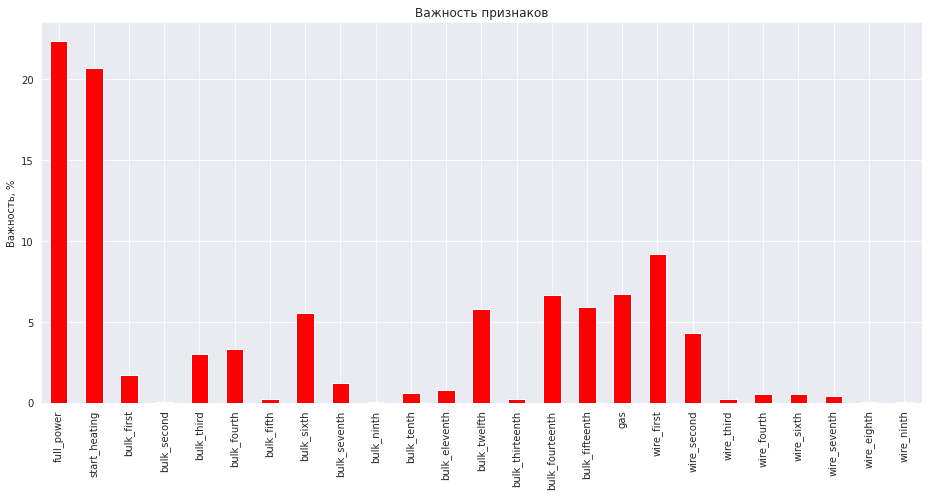

In [93]:
model_cat = CatBoostRegressor(learning_rate = 0.1, random_state = 110423, verbose = False)
model_cat.fit(features_train, target_train)

cat_imp = pd.Series(model_cat.get_feature_importance(),
                    features_train.columns)

fig, ax = plt.subplots(figsize=(13, 7))
cat_imp.plot.bar(ax=ax, color = 'red')
ax.set_title('Важность признаков')
ax.set_ylabel('Важность, %')
fig.tight_layout()

# Также посмотрим интерпритацию признаков 

**Нужно понять, на какие признаки модель обращает внимание и какие из них вносят наибольший вклад.**

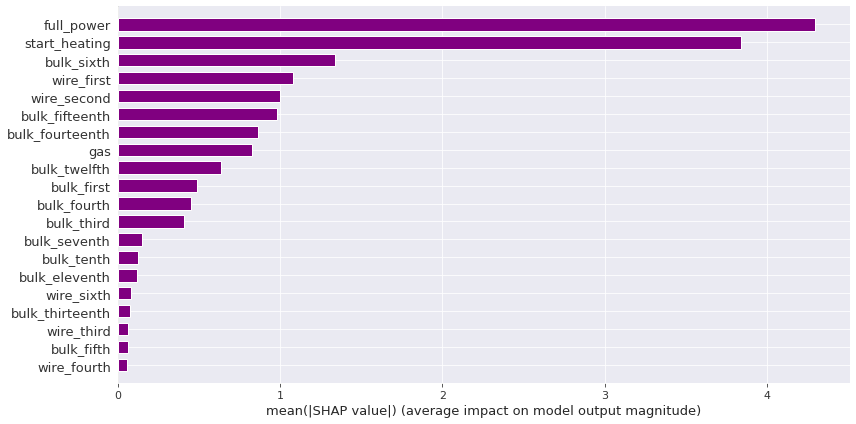

In [101]:
model_cat = CatBoostRegressor(learning_rate = 0.1, random_state = 110423, verbose = False)
model_cat.fit(features_train, target_train)

explainer = shap.TreeExplainer(model_cat)

shap_values = explainer.shap_values(features_train)

shap.summary_plot(shap_values, features_train, plot_type='bar', color = 'purple', plot_size=(12, 6))

**Согласно графику, наибольший вклад вносят следующие признаки:**

- полная мощность
- начальная температура
- добавление сыпучих материалов № 6
- добавление проволочных материалов № 1 и 2

# Результаты данного этапа работы

**Мы построили три модели - RandomForestRegressor, CatBoostRegressor, LGBMRegressor**. 

Лучший результат по метрике MAE показала модель **CatBoostRegressor**, её результат - **6.121472600818588** на обучающем наборе данных и **6.101784148375898** на тестовом.
Мы можем интерпретировать этот результат следующим образом: наша модель ошибается ~ на 6 градусов. 

Также мы построили гистограмму важности признаков, подробная интерпретация будет в отчёте для заказчика.

**На следующем этапе работы мы напишем отчёт для заказчика.**

## Отчёт для заказчика

# Поставленная задача 

Металлургическим комбинатом ООО «Так закаляем сталь» перед нами была поставлена цель оптимизировать производственные расходы, чтобы уменьшить потребление электроэнергии на этапе обработки стали.

**Нашей задачей было построить модель, которая предскажет финальную температуру стали, чтобы заказчик мог экспериментальным путём воспроизвести технологический процесс, не неся потерь, а на производстве тестировать лучший результат.**

# Первый этап 
На первом этапе работы мы провели исследовательский анализ данных.

 - в датасете с информацией об электродах мы заметили аномалию в столбце с реактивной мощностью - большое отрицательное значение. На построенных гистограммах распределения активной и реактивной мощности мы увидели смещённое нормальное распределение.
 - в датасете с информацией о сыпучих материалах мы отметили много пропущенных значений, которые означают, что сыпучие материалы не добавлялись в процессе плавки. На построенной диаграмме мы увидели, 12, 14 и 15 добавки были добавлены в значительно большем объёме, чем другие добавки, а добавки № 3, 4, 12, 14 и 15 добавляли больше всего раз. 
 - в датасете с информацией о газе мы не нашли пропущенных значений, а гистограмма показала смещённое нормальное распределение данных.
 - в датасете с информацией об измерении температуры были обнаружены пропуски и аномалия - температура ниже 1500 градусов. На гистограмме мы увидели нормальное распределение без смещения.
 - в датасете с информацией о проволочных материалах были обнаружены пропуски. Согласно столбчатой диаграмме, первую, вторую и третью проволоку при легировании стали добавляли чаще и в большем объеме, чем другие. 

# Второй этап 

На этапе предобработки данных мы сделали следующие шаги:
- поменяли типы данных в столбцах, где это требовалось
- поработали с аномалиями в данных (удалили температуру ниже 1500 градусов и отрицательный показатель реактивной мощности) 
- поработали с пропусками
- поработали с температурой - избавились от промежуточных и недостающих значений
- вывели несколько новых признаков для дальнейшего обучения нашей модели
- сформировали итоговую таблицу из всех интересующих нас признаков


# Третий этап

Следующим этапом мы построили три модели **RandomForestRegressor**, **CatBoostRegressor** и **LGBMRegressor**.

 - модель **RandomForestRegressor** показала хороший результат метрики MAE - **6.241650297722771**
с гиперпараметрами **max_depth = 11** и **n_estimators = 49**
 - модель **LGBMRegressor** показала результат MAE - **6.3516142934636495** с гиперпараметрами **learning_rate = 0.3**, **max_depth = 8** и **n_estimators = 9**. При этом модель обучается намного дольше двух других рассматриваемых нами моделей.
 - модель **CatBoostRegressor** показала лучший результат MAE на обучающей выборке - **6.121472600818588** с гиперпараметром **learning_rate = 0.1**. 
 
Мы проверили лучшую модель на тестовой выборке, модель также показала отличный результат.

**После того, как мы выбрали лучшую модель, с помощью графика мы посмотрели важность признаков. Наиболее важными оказались следующие признаки:**
- **полная мощность** и **начальная температура**
- добавление проволочных материалов **№ 1**, **продувка сплава газом** и добавление сыпучих материалов **№ 14**.

Наименьшую значимость показали признаки **bulk = 2, 5, 9 и 13**, **wire = 3, 8 и 9**.